# Four level atom steady state solution

### Written by Ohad Michel

First import all the required libraries 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from IPython.display import Image
import time

## Defining the problem

Our atom in this model has only 4 levels (no HF splitting), as can be seen below:

                               
                                                      -------|r>           
                                                         |                     
                                                         |  Omega_c                  
                                                         |                  
                                                      -------|e>       
                                          -------|a>     |              
                                                    \    |  Omega_p               
                                            Omega_a  \   |                 
                                                      -------|g>     
                     


We want to solve the master equations for this system in steady state, i.e solve:

\begin{equation}
\frac{d\rho}{dt}=\mathcal{L}[\rho]=0\cdot\rho,
\end{equation}

Where $\mathcal{L}$ is the Liouvillian superoperator which is defined as:

\begin{equation}
\mathcal{L}\left[\rho\right] = -\frac{i}{\hbar}\left[\mathcal{H},\rho\right] + \sum_i\left(c_i \rho c_i^\dagger - \frac{1}{2}c_i^\dagger c_i\rho -\frac{1}{2}\rho c_i^\dagger c_i\right)  
\end{equation}

Here $c_i \equiv \sqrt{2\Gamma_i} \left|\,f\rangle \langle i\,\right|$ is a colapse operator from initial state $\left|i\right>$ to final state $\left|f\right>$ and $\Gamma_i$ is the colapse rate in the half sense ($2\Gamma_i$ is the FWHM of the linewidth).

## Setup and Solution

First we define all the relevant parameters which we would use to construct the Hamiltonian and the colapse operator: Rabi frequencies and detuning of the lasers and decay rates of each level to the ground state.

### System parameters

In [2]:
# System Parameters (in units of MHz)
#-----------------------------------
MHz = 2*np.pi
Omega_p = 1e-2*MHz            # g-e levels Coupling strength (Half sence)
Omega_c = 180*MHz             # e-r levels Coupling strength (Half sence)
Omega_a = 140*MHz             # g-a levelsCoupling strength (Half sence)
Gamma = 6*MHz/2               # e-->g decay rate (Half sence)
gamma = 1.8*MHz #0.66*MHz/2        # r-->e level decay rate (Half sence)
gamma_a = 5.75*MHz/2          # a-->g level decay rate (Half sence)
Delta_c = 1050*MHz            # Control detuning
Delta_a = -1050*MHz           # Auxilliary detuning
Delta_p = -300*MHz            # Probe detuning
alpha = 2e2;                  # alpha coeff in kchi

### Defining some function for the Calculation

In [3]:
def premul(A):
    '''Tensor product for multiplication of rho from the lef'''
    return np.kron(np.identity(np.prod(A.shape[1])),A)

def postmul(A):
    '''Tensor product for multiplication of rho from the right'''
    return np.kron(A.T,np.identity(np.prod(A.shape[0])))

def Sstate1(H,Lind):
    '''Solve the Master equations using SVD - usually slower'''
    # Creating the Liouvillian superoperator
    
    L = -1.0j * (premul(H) - postmul(H)) + Lind
    
    # Using SVD to find the zero eigenvector
    
    U,s,V = np.linalg.svd(L,full_matrices=0)
    rho_vec = V[np.argmin(s)].H
    
    # Reshaping density matrix into matrix form
    
    rhoss = rho_vec.reshape(4,4).T
    return rhoss/rhoss.trace()

def Sstate2(H,Lind):
    '''Solve the Master equations using eigenvalues - usually faster'''
    # Creating Liouvillian superoperator
    
    L = -1.0j * (premul(H) - postmul(H)) + Lind
    
    # Using direct to find the zero eigenvector

    w = np.mean(np.abs(L))
    b = np.zeros(16, dtype = complex)
    b[0] = w
    
    L[0,:] = np.diag(w*np.ones(4)).reshape((1,16))
    V = np.linalg.solve(L,b).conj()
    
    # Reshaping density matrix into matrix form
    
    rhoss = V.reshape(4,4)
    return 0.5*(rhoss + rhoss.conj().T)

### Define the Hamiltonian and the decay operators

Here we define the entries of the Hamiltonian

In [4]:
# Omega_c matrix
Oc = np.matrix([[0,0,0,0],
                [0,0,1,0],
                [0,1,0,0],
                [0,0,0,0]],dtype = complex)

# Omega_a matrix
Oa = np.matrix([[0,0,0,1],
                [0,0,0,0],
                [0,0,0,0],
                [1,0,0,0]],dtype = complex)

# Omega_p matrix
Op = np.matrix([[0,1,0,0],
                [1,0,0,0],
                [0,0,0,0],
                [0,0,0,0]],dtype = complex)

# Excited state energy matrix
ee = np.matrix([[0,0,0,0],
                [0,1,0,0],
                [0,0,0,0],
                [0,0,0,0]],dtype = complex)

# r state energy matrix
rr = np.matrix([[0,0,0,0],
                [0,0,0,0],
                [0,0,1,0],
                [0,0,0,0]],dtype = complex)

# a state energy matrix
aa = np.matrix([[0,0,0,0],
                [0,0,0,0],
                [0,0,0,0],
                [0,0,0,1]],dtype = complex)

and the decay operators $c_{i f}=\sqrt{2\Gamma_i}\left|\,f\rangle \langle i\,\right|$

In [5]:
ceg = np.sqrt(2*Gamma)*np.matrix([[0,1,0,0],
                                  [0,0,0,0],
                                  [0,0,0,0],
                                  [0,0,0,0]],dtype = complex)

cre = np.sqrt(2*gamma)*np.matrix([[0,0,0,0],
                                  [0,0,1,0],
                                  [0,0,0,0],
                                  [0,0,0,0]],dtype = complex)

cag = np.sqrt(2*gamma_a)*np.matrix([[0,0,0,1],
                                    [0,0,0,0],
                                    [0,0,0,0],
                                    [0,0,0,0]],dtype = complex)

# Define a list of all the operators
c_ops = [ceg,cre,cag]

Create the Lindblad super-operator for all of the decay operators

In [6]:
Lind = 0
for c in c_ops:
        cdc = c.T*c
        Lind += premul(c)*postmul(c.T) -0.5*premul(cdc) -0.5*postmul(cdc)

## Hot atoms 

First let's define some parameters of the hot atoms ensemble:

In [7]:
# Hot atoms parameters
T = 273.15 + 70                    # Temperature in K
vth = np.sqrt(1.38e-23*T/1.44e-25) # Thermal velocity = sqrt(kB*T/m) in m/s
kp = 2*np.pi/(780.246e-9)          # Probe wave vector in 1/m
kc = -2*np.pi/(775.978e-9)         # Control wave vector in 1/m
ka = 2*np.pi/(794.985e-9)          # Aux wave vector in 1/m
dv = 1                             # Spacing between consequent velocities
v = np.arange(-400,400,dv)         # Velocity vector in m/s

The Aux parameters which we found for Doppler compensation are:

In [8]:
# epsD = 1-np.abs(kp/kc)
# Delta_a = - np.abs(ka/kc)*(1+epsD*Delta_c**2/Omega_c**2)*Delta_c
# Omega_a = np.sqrt(np.abs(kp/kc)*(1+epsD*Delta_c**2/Omega_c**2)**3)*Omega_c
# print Delta_a/MHz, Omega_a/MHz

Compute the spectrum:

In [9]:
t1 = time.time()

TPA = 1  # 1 for TPA, 0 for 1-photon

if Delta_c !=0:
    CLS = (Delta_c/2 * (1 + np.sqrt(1 + 4*Omega_c**2/Delta_c**2)) - Delta_c)/MHz            # Control Light shift
    ALS = (Delta_a/2 * (1 + np.sqrt(1 + 4*Omega_a**2/Delta_a**2)) - Delta_a)/MHz            # Aux Light shift
    Dc = Delta_c/MHz

if TPA == 1:
    Delta_p_array = np.arange(-Dc-(CLS+ALS) -20,-Dc-(CLS+ALS) +20,0.15)*MHz         # Probe scanning range Raman
elif TPA==0:
    Delta_p_array = np.arange(CLS-ALS - 10,CLS-ALS + 10,0.3)*MHz                  # Probe scanning range 1-photon
else:
    Delta_p_array = np.arange(-150,150,0.3)*MHz                  # Probe scanning range EIT

rho_eg_mat = np.matrix(np.empty([len(Delta_p_array),len(v)],dtype=complex))   # Matrix of rho_eg for velocity & detuning
rho_eg = np.empty_like(Delta_p_array,dtype=complex)                           # rho_eg vector after summing all velocities
MBfactor = np.matrix(dv*np.exp(-1/2*(v**2/vth**2))/(np.sqrt(2*np.pi)*vth)).T  # Maxwell-Boltzman factor vector

Delta_cH = Delta_c - kc*v/1e6
Delta_aH = Delta_a - ka*v/1e6
v_mat,D_mat = np.meshgrid(v,Delta_p_array)
Delta_pH = D_mat - kp*v_mat/1e6

for m in range(len(v)):
    
    for n in range(len(Delta_p_array)):
        
        H = -(Delta_pH[n,m]*ee + (Delta_pH[n,m] + Delta_cH[m])*rr + Delta_aH[m]*aa + Omega_p*Op +
          Omega_c*Oc + Omega_a*Oa)
        rho_n = Sstate2(H, Lind)
        rho_eg_mat[n,m] = rho_n[1,0]
    
rho_eg = rho_eg_mat*MBfactor
kchi = alpha*Gamma*rho_eg/Omega_p
t2 = time.time()
t2-t1

407.98800015449524

Plot the spectrum:

<IPython.core.display.Javascript object>


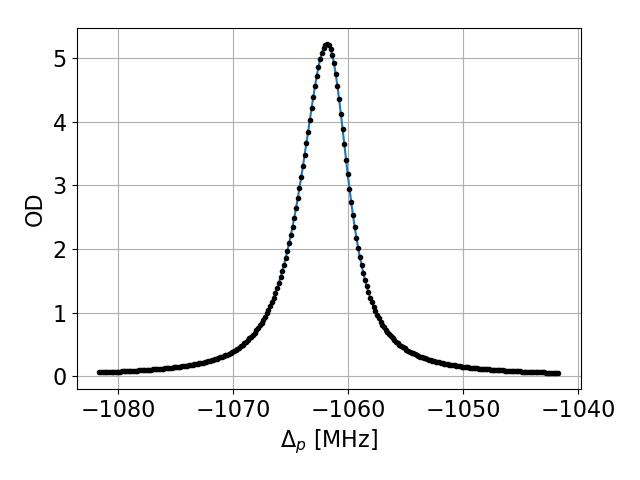

In [10]:
plt.rcParams.update({'font.size': 16})
fig4 = plt.figure()
plt.plot(Delta_p_array/MHz,kchi.imag,'-')
plt.plot(Delta_p_array/MHz,kchi.imag,'k.')
plt.xlabel(r"$\Delta_p$ [MHz]")
plt.ylabel('OD')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


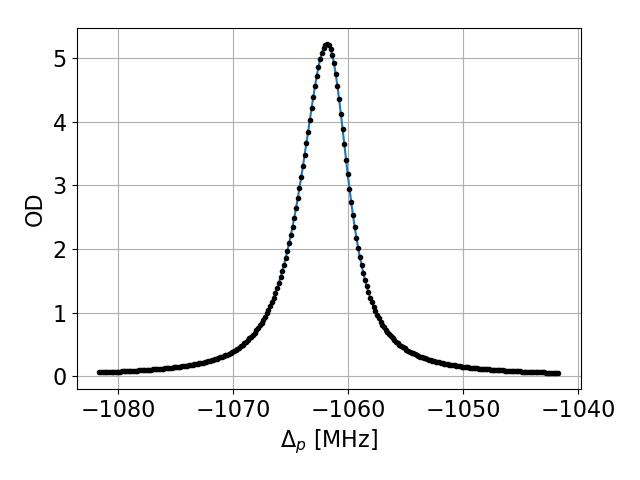

In [11]:
plt.rcParams.update({'font.size': 16})
fig4 = plt.figure()
plt.plot(Delta_p_array/MHz,kchi.imag,'-')
plt.plot(Delta_p_array/MHz,kchi.imag,'k.')
plt.xlabel(r"$\Delta_p$ [MHz]")
plt.ylabel('OD')
plt.grid()
plt.tight_layout()

In [12]:
Omega_a = 0

In [13]:
# plt.savefig('1.png', format = 'png', dpi = 1000)

Peak detection (similar to findpeaks in MATLAB) using a function by Marcos Duarte, https://github.com/demotu/BMC:

<IPython.core.display.Javascript object>


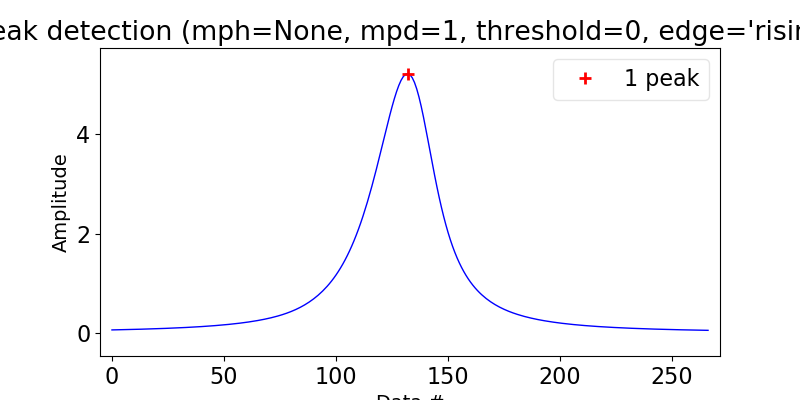

center is -1062
amplitude is 5.22
HWHM is 15.1


In [14]:
from detect_peaks import detect_peaks
spectra = np.ravel(kchi.imag)
ind = detect_peaks(spectra, show=True)
center = Delta_p_array[ind]/MHz
amplitude = float(spectra[ind])
HW_Delta_p = Delta_p_array[spectra>0.5*amplitude]
HWHM = (HW_Delta_p[-1] - HW_Delta_p[0])/2
print 'center is %.f' %center
print 'amplitude is %.3g' %amplitude
print 'HWHM is %.3g' %HWHM